In [1]:
import pandas as pd
import re
from collections import defaultdict, Counter
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
# Load the datasets
train_data = pd.read_csv('train.tsv', sep='\t', header=None, names=["Text", "Label"]).iloc[1:].reset_index(drop=True)
valid_data = pd.read_csv('valid.tsv', sep='\t', header=None, names=["Text", "Label"]).iloc[1:].reset_index(drop=True)

# Preprocess text function
# Import stop words from the NLTK library

# Download stopwords list if not already available
# nltk.download('stopwords')
stop_words = set(stopwords.words('english'))


def preprocess_text(text):
    text = text.lower()  
    # Remove Unicode escape sequences
    text = re.sub(r'\\u[0-9a-fA-F]{4}', '', text)
    # Remove words starting with special characters
    text = re.sub(r'\B[@#]\w+', '', text)
    # Tokenize by words and remove non-alphabetic characters
    tokens = re.findall(r'\b[a-z]+\b', text)
    # Remove stop words
    filtered_tokens = []
    for token in tokens:
        if token not in stop_words:
            filtered_tokens.append(token)

    # Generate n-grams (using bigrams as an example here)
    ngrams_tokens = list(ngrams(filtered_tokens, 1))
    
    # Convert n-grams tuples to strings for easier readability
    ngrams_tokens = [' '.join(gram) for gram in ngrams_tokens]
    
    return ngrams_tokens

# Apply preprocessing with stop word removal
train_data['Tokens'] = train_data['Text'].apply(preprocess_text)
valid_data['Tokens'] = valid_data['Text'].apply(preprocess_text)



In [2]:
# Count the number of documents per class
class_counts = train_data['Label'].value_counts()
total_docs = len(train_data)
print('class counts:', class_counts)
print('total docs:', total_docs)
# Calculate class priors P(class)
class_priors = {}
for cls, count in class_counts.items():
    class_priors[cls] = count / total_docs
print('class priors:', class_priors)
# Word counts for each class
word_counts = defaultdict(Counter)
total_words_in_class = defaultdict(int)

# Populate word counts per class
for _, row in train_data.iterrows():
    label = row['Label']
    tokens = row['Tokens']
    word_counts[label].update(tokens)
    total_words_in_class[label] += len(tokens)
print('word counts:', word_counts)
print('total words in class:', total_words_in_class)

# Vocabulary size
vocabulary = set()
for words in word_counts.values():
    for word in words:
        vocabulary.add(word)
vocab_size = len(vocabulary)
print('vocabulary:', vocabulary)
print('vocab size:', vocab_size)

# Calculate word likelihoods with Laplace smoothing
word_likelihoods = defaultdict(dict)
for cls, counts in word_counts.items():
    for word in vocabulary:
        word_likelihoods[cls][word] = (counts[word] + 1) / (total_words_in_class[cls] + vocab_size)
print('word likelihoods:', word_likelihoods)

class counts: Label
negative    613
neutral     613
positive    613
Name: count, dtype: int64
total docs: 1839
class priors: {'negative': 0.3333333333333333, 'neutral': 0.3333333333333333, 'positive': 0.3333333333333333}
word counts: defaultdict(<class 'collections.Counter'>, {'negative': Counter({'may': 127, 'tomorrow': 87, 'like': 57, 'going': 45, 'one': 39, 'night': 33, 'get': 33, 'day': 33, 'go': 32, 'sunday': 32, 'time': 30, 'think': 28, 'see': 28, 'would': 24, 'last': 23, 'world': 23, 'sat': 21, 'really': 20, 'monday': 20, 'new': 19, 'muslims': 19, 'watch': 19, 'even': 19, 'im': 18, 'amp': 18, 'still': 18, 'want': 18, 'sun': 18, 'friday': 18, 'got': 18, 'u': 18, 'right': 17, 'game': 17, 'people': 17, 'obama': 16, 'well': 16, 'make': 16, 'play': 15, 'said': 15, 'gonna': 15, 'show': 15, 'bad': 15, 'shit': 15, 'way': 15, 'cant': 14, 'season': 14, 'today': 14, 'lol': 14, 'thursday': 14, 'know': 14, 'sad': 14, 'dont': 13, 'say': 13, 'yakub': 13, 'much': 13, 'take': 13, 'actually': 13,

In [3]:
# Naive Bayes classification
def classify_naive_bayes(tokens):
    class_scores = {}
    for cls in class_priors:
        # Start with the prior log probability of the class
        score = class_priors[cls]
        for token in tokens:
            # Multiply by word likelihood; add Laplace smoothing in case of missing words
            score *= word_likelihoods[cls].get(token, 1 / (total_words_in_class[cls] + vocab_size))
        class_scores[cls] = score
    
    # Return the class with the highest probability score
    return max(class_scores, key=class_scores.get)

# Classify the validation set
valid_data['Predicted'] = valid_data['Tokens'].apply(classify_naive_bayes)


In [4]:
# Calculate accuracy
accuracy = (valid_data['Predicted'] == valid_data['Label']).mean()
print(f"Model Accuracy: {accuracy * 100:.2f}%")


Model Accuracy: 57.41%


In [6]:
# Display significant values
for cls in class_priors:
    print(f"Sample Word Likelihoods for '{cls}':")
    top_words = sorted(word_likelihoods[cls].items(), key=lambda x: x[1], reverse=True)[:100]
    for word, prob in top_words:
        print(f"  {word}: {prob:.5f}")
    print()


Sample Word Likelihoods for 'negative':
  may: 0.00991
  tomorrow: 0.00681
  like: 0.00449
  going: 0.00356
  one: 0.00310
  get: 0.00263
  day: 0.00263
  night: 0.00263
  go: 0.00256
  sunday: 0.00256
  time: 0.00240
  see: 0.00225
  think: 0.00225
  would: 0.00194
  world: 0.00186
  last: 0.00186
  sat: 0.00170
  monday: 0.00163
  really: 0.00163
  muslims: 0.00155
  even: 0.00155
  watch: 0.00155
  new: 0.00155
  friday: 0.00147
  got: 0.00147
  im: 0.00147
  sun: 0.00147
  want: 0.00147
  amp: 0.00147
  u: 0.00147
  still: 0.00147
  game: 0.00139
  right: 0.00139
  people: 0.00139
  well: 0.00132
  obama: 0.00132
  make: 0.00132
  bad: 0.00124
  play: 0.00124
  gonna: 0.00124
  show: 0.00124
  said: 0.00124
  way: 0.00124
  shit: 0.00124
  thursday: 0.00116
  know: 0.00116
  season: 0.00116
  sad: 0.00116
  cant: 0.00116
  lol: 0.00116
  today: 0.00116
  actually: 0.00108
  yakub: 0.00108
  much: 0.00108
  dont: 0.00108
  take: 0.00108
  say: 0.00108
  news: 0.00101
  place: 0.0010

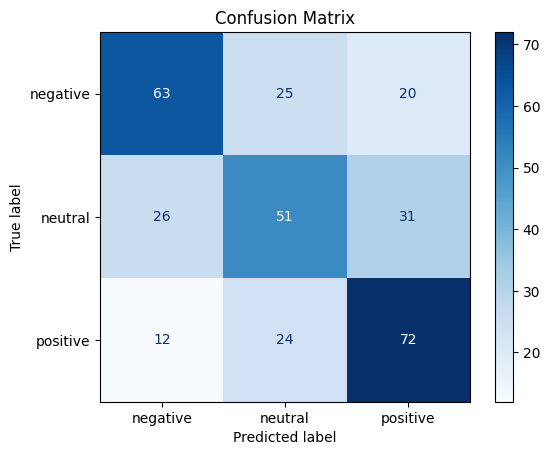

In [8]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Ensure class_priors.keys() is converted to a list
class_labels = list(class_priors.keys())

# Calculate predictions
valid_data['Predicted'] = valid_data['Tokens'].apply(classify_naive_bayes)

# Compute confusion matrix
true_labels = valid_data['Label']  # Actual labels
predicted_labels = valid_data['Predicted']  # Predicted labels

# Create the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=class_labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
